# Plot profiles of mean quantities from various simulations for comparisons

In [1]:
%matplotlib inline
# import functions from python directory
import sys
sys.path.append("../python")
import os
import seaborn
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
from LESnc import load_stats, load_full

In [2]:
# plotting setup
rc('font',weight='normal',size=20,family='serif',serif='Times New Roman')
rc('text',usetex='True')
cmaps = [plt.get_cmap("Greys"), plt.get_cmap("Blues"), plt.get_cmap("Reds"), plt.get_cmap("Purples")]
cmap1 = seaborn.color_palette("crest", as_cmap=True)
cmap2 = seaborn.color_palette("cubehelix_r", as_cmap=True)

In [11]:
# directories
# figure save
figdir = "/home/bgreene/SBL_LES/figures/quadrant/"
# list of simulations to loop over
sims = ["cr0.10_u08", "cr0.25_u08", "cr0.33_u08", "cr0.50_u08", 
        "cr0.10_u01", "cr0.25_u01", "cr0.10_u15", "cr0.50_u15"]
# empty list to construct paths and store
dnc_all = []
sall = []
# loop over sims and load stats data
for sim in sims:
    dnc = f"/home/bgreene/simulations/{sim}_192/output/netcdf/"
    dnc_all.append(dnc)
    # load stats file
    s = load_stats(dnc+"average_statistics.nc")
    sall.append(s)

# define colormap based on number of simulations
nsim = len(sims)
cmap = seaborn.color_palette("cubehelix_r", nsim)

Reading file: /home/bgreene/simulations/cr0.10_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr0.25_u08_192/output/netcdf/average_statistics.nc


/home/bgreene/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:742: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Reading file: /home/bgreene/simulations/cr0.33_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr0.50_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr0.10_u01_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr0.25_u01_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr0.10_u15_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr0.50_u15_192/output/netcdf/average_statistics.nc


### Figure 1: $u$, $v$, $u_h$, $\theta$

No handles with labels found to put in legend.


Text(0.5, 0, '$\\langle \\theta \\rangle$ [K]')

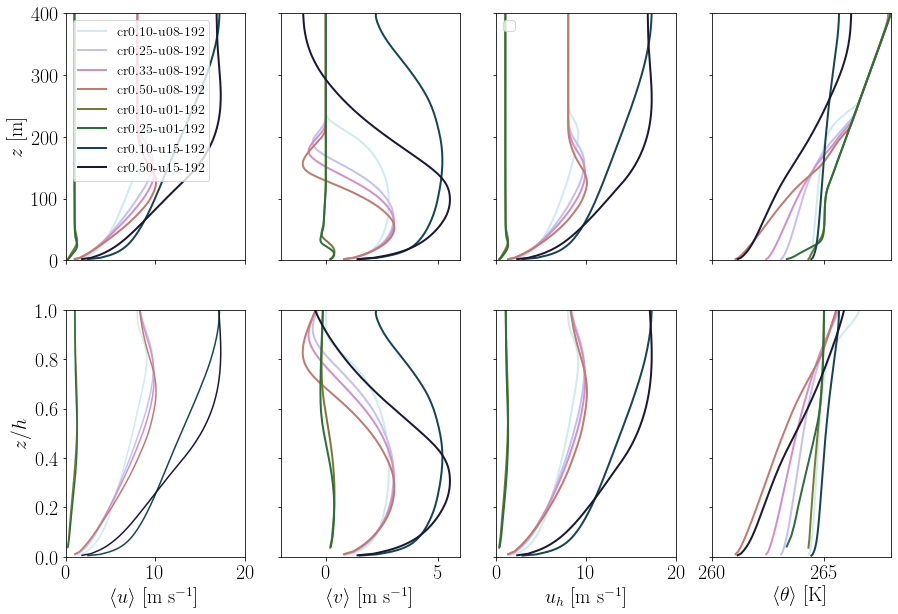

In [19]:
# figure 1: u, v, theta versus z - NOT normalized; u, v, theta vs z/h
fig1, ax1 = plt.subplots(nrows=2, ncols=4, sharey="row", sharex="col", figsize=(14.8, 10))
# loop over sims
for js, s in enumerate(sall):
    # row 1: dimensional
    # a) u
    ax1[0,0].plot(s.u_mean, s.z, ls="-", lw=2, c=cmap[js], 
                label="-".join(s.stability.split("_")))
    # b) v
    ax1[0,1].plot(s.v_mean, s.z, ls="-", lw=2, c=cmap[js])
    # c) ws
    ax1[0,2].plot(s.uh, s.z, ls="-", lw=2, c=cmap[js])
    # d) theta
    ax1[0,3].plot(s.theta_mean, s.z, ls="-", lw=2, c=cmap[js],
                label=f"$h/L = {{{s.hL.values:3.2f}}}$")
    # row 2: normalized z/h
    # e) u
    ax1[1,0].plot(s.u_mean, s.z/s.he, ls="-", c=cmap[js])
    # f) v
    ax1[1,1].plot(s.v_mean, s.z/s.he, ls="-", lw=2, c=cmap[js])
    # g) uh
    ax1[1,2].plot(s.uh, s.z/s.he, ls="-", lw=2, c=cmap[js])
    # h) theta
    ax1[1,3].plot(s.theta_mean, s.z/s.he, ls="-", lw=2, c=cmap[js])    

# clean up
ax1[0,0].legend(fontsize=14, loc="upper left")
ax1[0,0].set_ylim([0, 400])
ax1[0,0].set_ylabel("$z$ [m]")

ax1[0,2].legend(fontsize=14, loc="upper left")

ax1[1,0].set_ylim([0, 1])
ax1[1,0].set_ylabel("$z/h$")
ax1[1,0].set_xlim([0, 20])
ax1[1,0].set_xlabel("$\\langle u \\rangle$ [m s$^{-1}$]")

ax1[1,1].set_xlim([-2, 6])
ax1[1,1].set_xlabel("$\\langle v \\rangle$ [m s$^{-1}$]")

ax1[1,2].set_xlim([0, 20])
ax1[1,2].set_xlabel("$u_h$ [m s$^{-1}$]")

ax1[1,3].set_xlim([260, 268])
ax1[1,3].set_xlabel("$\\langle \\theta \\rangle$ [K]")

### Figure 2: Fluxes

Text(0.5, 0, "$\\langle \\theta' w' \\rangle / u_{*0} \\theta_{*0}$")

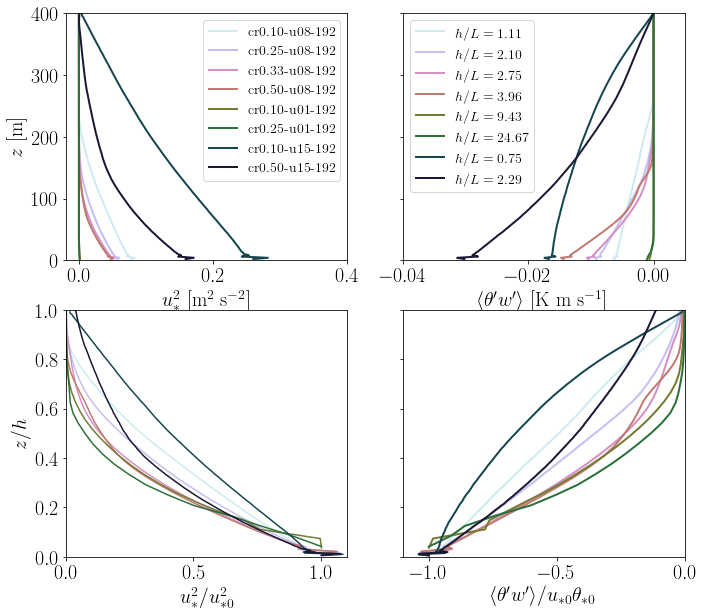

In [16]:
# figure 2: ustar^2, theta'w'
fig2, ax2 = plt.subplots(nrows=2, ncols=2, sharey="row", figsize=(11.1, 10))
# loop over sims
for js, s in enumerate(sall):
    # row 1: dimensional
    # a) ustar^2
    ax2[0,0].plot(s.ustar2, s.z, ls="-", lw=2, c=cmap[js], 
                  label="-".join(s.stability.split("_")))
    # b) theta'w'
    ax2[0,1].plot(s.tw_cov_tot, s.z, ls="-", lw=2, c=cmap[js],
                  label=f"$h/L = {{{s.hL.values:3.2f}}}$")
    # row 2: normalized z/h, u*, theta*
    # d) ustar2 / ustar0^2
    ax2[1,0].plot(s.ustar2/s.ustar0/s.ustar0, s.z/s.he, ls="-", c=cmap[js])
    # e) v/ustar
    ax2[1,1].plot(s.tw_cov_tot/s.ustar0/s.tstar0, s.z/s.he, ls="-", lw=2, c=cmap[js])

# labels
ax2[0,0].legend(fontsize=14)
ax2[0,0].set_ylim([0, 400])
ax2[0,0].set_ylabel("$z$ [m]")
ax2[0,0].set_xlim([-0.02, 0.4])
ax2[0,0].set_xlabel("$u_{*}^2$ [m$^2$ s$^{-2}$]")

ax2[0,1].legend(fontsize=14)
ax2[0,1].set_xlim([-0.04, 0.005])
ax2[0,1].set_xlabel("$\\langle \\theta' w' \\rangle$ [K m s$^{-1}$]")

ax2[1,0].set_ylim([0, 1])
ax2[1,0].set_ylabel("$z/h$")
ax2[1,0].set_xlim([0, 1.1])
ax2[1,0].set_xlabel("$u_{*}^2 / u_{*0}^2$")

ax2[1,1].set_xlim([-1.1, 0])
ax2[1,1].set_xlabel("$\\langle \\theta' w' \\rangle / u_{*0} \\theta_{*0}$")

### Figure 3: variances urot, vrot, w, theta

Text(0.5, 0, "$\\langle \\theta'\\theta' \\rangle / \\theta_{*0}^2$")

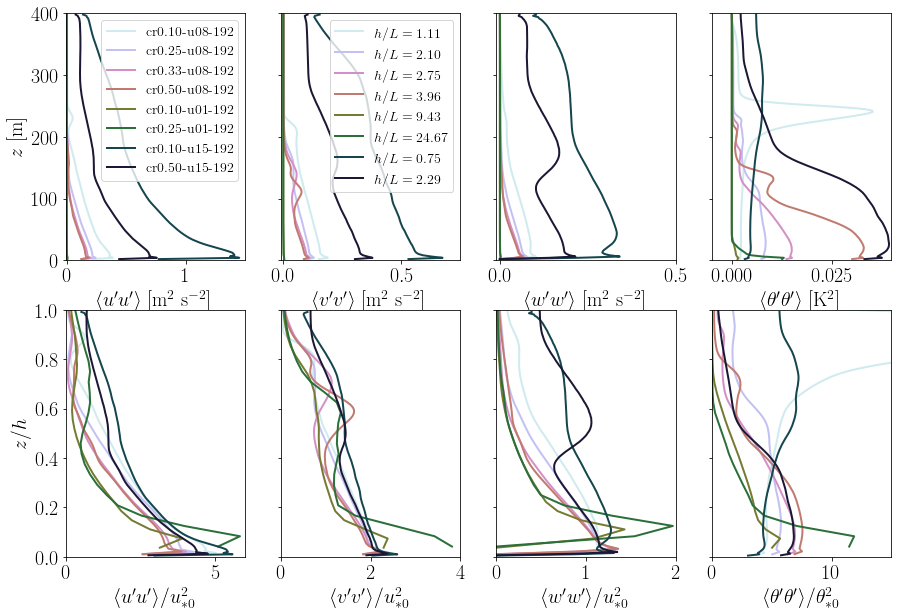

In [27]:
# figure 3: u'u', v'v', w'w', t't'
fig3, ax3 = plt.subplots(nrows=2, ncols=4, sharey="row", figsize=(14.8, 10))
# loop over sims
for js, s in enumerate(sall):
    # row 1: dimensional
    # a) u'u'
    ax3[0,0].plot(s.u_var_rot, s.z, ls="-", lw=2, c=cmap[js], 
                  label="-".join(s.stability.split("_")))
    # b) v'v'
    ax3[0,1].plot(s.v_var_rot, s.z, ls="-", lw=2, c=cmap[js],
                  label=f"$h/L = {{{s.hL.values:3.2f}}}$")
    # c) w'w'
    ax3[0,2].plot(s.w_var, s.z, ls="-", lw=2, c=cmap[js])
    # d) t't'
    ax3[0,3].plot(s.theta_var, s.z, ls="-", lw=2, c=cmap[js])
    # row 2: normalized z/h, u*, theta*
    # e) u'u'/ustar2
    ax3[1,0].plot(s.u_var_rot/s.ustar0/s.ustar0, s.z/s.he, ls="-", lw=2, c=cmap[js])
    # f) v'v'/ustar2
    ax3[1,1].plot(s.v_var_rot/s.ustar0/s.ustar0, s.z/s.he, ls="-", lw=2, c=cmap[js])
    # g) w'w'/ustar2
    ax3[1,2].plot(s.w_var/s.ustar0/s.ustar0, s.z/s.he, ls="-", lw=2, c=cmap[js])
    # h) t't'/tstar2
    ax3[1,3].plot(s.theta_var/s.tstar0/s.tstar0, s.z/s.he, ls="-", lw=2, c=cmap[js])

# labels
ax3[0,0].legend(fontsize=14)
ax3[0,0].set_ylim([0, 400])
ax3[0,0].set_ylabel("$z$ [m]")
ax3[0,0].set_xlim([-0.01, 1.5])
ax3[0,0].set_xlabel("$\\langle u'u' \\rangle$ [m$^2$ s$^{-2}$]")

ax3[0,1].legend(fontsize=14)
ax3[0,1].set_xlim([-0.01, 0.75])
ax3[0,1].set_xlabel("$\\langle v'v' \\rangle$ [m$^2$ s$^{-2}$]")

ax3[0,2].set_xlim([-0.01, 0.5])
ax3[0,2].set_xlabel("$\\langle w'w' \\rangle$ [m$^2$ s$^{-2}$]")

ax3[0,3].set_xlim([-0.005, 0.04])
ax3[0,3].set_xlabel("$\\langle \\theta'\\theta' \\rangle$ [K$^2$]")

ax3[1,0].set_ylim([0, 1])
ax3[1,0].set_ylabel("$z/h$")
ax3[1,0].set_xlim([0, 6])
ax3[1,0].set_xlabel("$\\langle u'u' \\rangle / u_{*0}^2$")

ax3[1,1].set_xlim([0, 4])
ax3[1,1].set_xlabel("$\\langle v'v' \\rangle / u_{*0}^2$")

ax3[1,2].set_xlim([0, 2])
ax3[1,2].set_xlabel("$\\langle w'w' \\rangle / u_{*0}^2$")

ax3[1,3].set_xlim([0, 15])
ax3[1,3].set_xlabel("$\\langle \\theta'\\theta' \\rangle / \\theta_{*0}^2$")

### Figure 4: Richardson numbers and Prandtl

Text(0.5, 0, '$Pr_t = Ri_g/ Ri_f$')

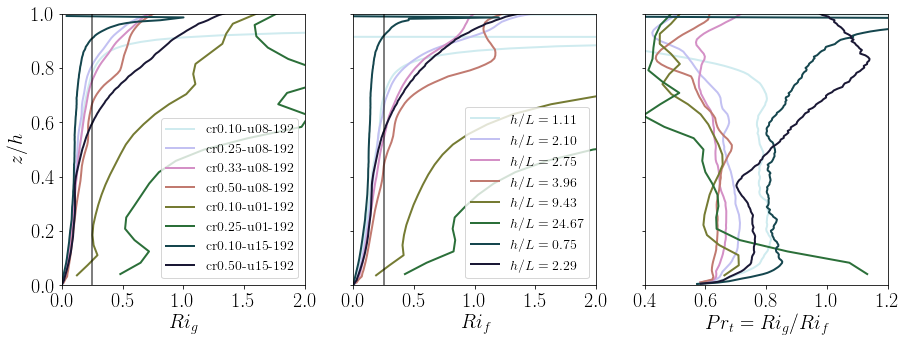

In [18]:
# figure 4: Ri_g, Ri_f, Pr_t
fig3, ax3 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14.8, 5))
# loop over sims
for js, s in enumerate(sall):
    # a)Ri_g
    ax3[0].plot(s.Rig, s.z/s.he, ls="-", lw=2, c=cmap[js], 
                label="-".join(s.stability.split("_")))
    # b) v'v'
    ax3[1].plot(s.Rif, s.z/s.he, ls="-", lw=2, c=cmap[js],
                label=f"$h/L = {{{s.hL.values:3.2f}}}$")
    # c) w'w'
    ax3[2].plot(s.Rig/s.Rif, s.z/s.he, ls="-", lw=2, c=cmap[js])

# labels
ax3[0].legend(fontsize=14)
ax3[0].set_ylim([0, 1])
ax3[0].set_ylabel("$z/h$")
ax3[0].set_xlim([0, 2])
ax3[0].set_xlabel("$Ri_g$")
ax3[0].axvline(0.25, c="k", lw=2, alpha=0.5)

ax3[1].legend(fontsize=14)
ax3[1].set_xlim([0, 2])
ax3[1].set_xlabel("$Ri_f$")
ax3[1].axvline(0.25, c="k", lw=2, alpha=0.5)

ax3[2].set_xlim([0.4, 1.2])
ax3[2].set_xlabel("$Pr_t = Ri_g/ Ri_f$")

In [10]:
print("zj", "h", "zj/h")
for s in sall:
    print(f"{s.zj.values:3.1f}", f"{s.he.values:3.1f}", f"{(s.zj/s.he).values:4.3f}")

zj h zj/h
203.1 259.1 0.784
155.4 207.3 0.750
140.9 196.9 0.716
126.4 188.6 0.670
33.2 56.0 0.593
24.9 49.7 0.500
397.9 401.4 0.991
